# Introduction to Object Detection with TensorFlow
*Author: Abel Brown (abelb@nvidia.com)*
<img src="sheep.png" alt="Drawing" style="width: 600px;"/>
<p style="text-align: center;color:gray"> *Image credit: Lin et al, Microsoft COCO: Common Objects in Context*  </p>


Welcome to an Introduction to Object Detection with TensorFlow.  The ultimate goal of this lab is to get you working with state-of-the-art object detection algorithms as fast as possible while building a good foundation for future exploration. You will learn how to configure the Google [Object Detection API](https://github.com/tensorflow/models/tree/master/object_detection) in [TensorFlow](https://www.tensorflow.org/) and evaluate detection performance working with the [Common Objects in Context](http://mscoco.org/) (COCO) data set from [Microsoft](https://www.microsoft.com/en-us/research/).  The TensorFlow Object Detection API is an open source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models.  Within the object detection API there are five different detection models based on recent advancements in deep learning:
1. Single Shot Multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) with [MobileNets](https://arxiv.org/abs/1704.04861)
2. SSD with [Inception v2](https://arxiv.org/abs/1512.00567)
3. [Region-Based Fully Convolutional Networks](https://arxiv.org/abs/1605.06409) (R-FCN) with [Resnet](https://arxiv.org/abs/1512.03385) 101
4. [Faster RCNN](https://arxiv.org/abs/1506.01497) with Resnet 101
5. Faster RCNN with [Inception Resnet v2](https://arxiv.org/abs/1602.07261)

All these models are pre-trained using the rich COCO dataset of more than 80,000 annotated images.  The API also includes [scripts](https://github.com/tensorflow/models/blob/master/object_detection/train.py) and [instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/running_locally.md) for creating or extending the API with your own data to create models specifically tuned for your application.

With all these models comes the fundemental engineering trade-off of accuracy versus performance.  The lightweight SSD with MobileNets model offer fast inference times around 40 milliseconds per frame (25 fps) but is considerably less accurate than the Faster RCNN with Inception Resnet v2 having an inference time of about 47 seconds per image.  Therefore, it is important to think carefully about the time and accuracy constraints of your particular problem (real-time, mobile, embedded, off-line, cluster, etc) and choose the appropriate network/model accordingly.  See [here](https://arxiv.org/abs/1611.10012) for further discussion regarding the speed and accuracy trade-offs in modern convolutional object detectors. 

Let's get started ...

In [89]:
import os
import io
import sys
import PIL
import json
import copy
import random
import zipfile
import tarfile
import operator
import collections

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import six.moves.urllib as urllib

import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

%matplotlib inline

### 1.1 Setup
- COCO annotations
- TensorFlow API from GitHub

The first thing we need are the COCO image annotations which provide human readable labels for the numeric detection identifiers produce by the models. For example, a "1" means "person", "2" means "car" and so on. 

In [90]:
%%bash

# get the coco annotations if needed ... 

# make coco dir if not exist already
[ ! -d coco ] && mkdir coco

# move into the coco dir
cd coco

# define URL for the COCO annotations 
URL="http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# download COCO annotations if not exist
[ ! -f annotations/instances_train2017.json ] && wget --quiet ${URL} && unzip annotations_trainval2017.zip

# we're done here 
cd ..

In [91]:
# define a relative path to the coco annotations JSON definitions 
json_annotations_file_path = os.path.join('coco','annotations','instances_train2017.json')

# import the coco annotation information (big file, takes a few seconds)
with open(json_annotations_file_path) as dat: data = json.load(dat)

In [92]:
# lets build an dictionary that converts/maps category numeric IDs to human readable strings
# we will use this mapping to translate the numeric network output to something we humans can interperet

# init empty dictionary for mapping
class_id_index = dict()

# iterate over categories defined in the coco annotations metadata
for category in data['categories']: 
    
    # get the category identifier
    category_id = category['id']
    
    # get the name of the category
    category_name= category['name']
    
    # get the super category
    supercategory = category['supercategory']
    
    # create mapping/entry for this category id to humany readable string
    class_id_index[category_id] = '{}/{}'.format(supercategory, category_name)

#### Sanity Check:
Add a code cell below and have a look at a few key value pairs from the `class_id_index` dictionary.  For exmaple: what string value does class_id_index[1] return?  You can get all valid dictionary keys with `class_id_index.keys()`

In [93]:
# your code goes here

Next we need to clone the TensorFlow [Models repository](https://github.com/tensorflow/models) from GitHub, install Google [Proto Buffers](https://developers.google.com/protocol-buffers/), Python Image Library ([PIL](https://en.wikipedia.org/wiki/Python_Imaging_Library)), [LXML](http://lxml.de/), and compile the protobuf XML definitions for the models into Python.  See full installation instruction [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md).

In [94]:
%%bash

# get the Google TensorFlow Object Detection API if needed 

# if no models dir then just clone git repo 
[ ! -d models ] && git clone https://github.com/tensorflow/models.git

# install deps: protoc, PIL, and lxml
#apt-get install -y protobuf-compiler python-pil python-lxml

# move into the TF models dir
cd models/research

# compile proto buf definitions for models
protoc object_detection/protos/*.proto --python_out=.

# fin 
cd ../..

There are five pre-trained models included in the object detection API.  Lets create some model IDs and a list of all the models

### 1.2 Configuration
- model identification
- downloading model weights
- loading models in TensorFlow
- initialize session in TensorFlow for our model

There are five models currently avaliable that we can use right out of the box.  As a light weight form of version control, these models were created on June 11, 2017 and that date is encoded into the file names for the models.  

In [95]:
# there are a few models we can use out-of-the-box

# create date id for when these models were last updated (June 11, 2017)
date = '11_06_2017'

# create model identifiers
model_0 = 'ssd_mobilenet_v1_coco'
model_1 = 'ssd_inception_v2_coco'
model_2 = 'rfcn_resnet101_coco'
model_3 = 'faster_rcnn_resnet101_coco'
model_4 = 'faster_rcnn_inception_resnet_v2_atrous_coco'

# throw everything together into a list of model ids
list_of_models = [model_0, model_1, model_2, model_3, model_4]

The API models are quite large and so they can not be checked into a typical GIT repository (see [here](https://help.github.com/articles/what-is-my-disk-quota/)).  Therefore, we need to manually download the model weights for each pre-trained network.  Since the models are quite large, we do not want to download them more than once.  It is important to check if the files exist locally first before attempting to download the weights.  Notice that for each model we download the associated serialized protobuf object `frozen_inference_graph.pb`.  You can think of this serialized network as platform agnostic representation of the model and weights.  When the model is inflated or deserialized, the local Proto Buffer implementation will sort out any platform dependent issues.

In [96]:
# this is the url where we download models for the Google Object Detection API
download_url = 'http://download.tensorflow.org/models/object_detection/'

In [97]:
# iterate over model ids and download+decompress if needed

# contenet root for object detection assets
rootdir = os.path.join('models','research','object_detection')

# acquire the models from the internets
for model in list_of_models:
    
    # create identifier for model
    model_id = model + '_'+ date
    
    # create the full name of the model file
    file_name = model_id + '.tar.gz'
    
    # create path to the model file
    file_path = os.path.join(rootdir, file_name)
    
    # this is the file we ultimately want for each model
    net_proto_buf_file = os.path.join(rootdir,model_id,'frozen_inference_graph.pb')
    
    # check for proto buf network definition file first
    if os.path.isfile(net_proto_buf_file):
        
        # compute the file size
        fsize = os.path.getsize(net_proto_buf_file)
        
        # confort signal
        print 'model already exists: ({:7.2f} MB) {}'.format(fsize/1024/1024,model)
        
        # move to the next model
        continue
    
    # check if the file already exists ...
    if os.path.isfile(file_path):
        
        # compute the file size
        fsize = os.path.getsize(file_path)
        
        # comfort signal for humans
        print 'model already exists: ({:7.2f} MB) {}'.format(fsize/1024/1024,model)
        
        # skip download etc b/c file already exists
        continue
        
    # comfort signal
    print 'acquiring model {0}'.format(model)
    
    # construct the full url for this file
    url = download_url + file_name
    
    # init URL request
    opener = urllib.request.URLopener()
    
    # retreive the model file from the url
    opener.retrieve(url, file_path)
    
    # open the tar file for extract contents
    tar_file = tarfile.open(file_path)
    
    # for each file in the archive ... 
    for content in tar_file.getmembers():
        
        # strip out just file name
        fname = os.path.basename(content.name)
        
        # if this is a inference graph ...
        if 'frozen_inference_graph.pb' in fname:
            
            # compute the file size
            fsize = os.path.getsize(file_path)
            
            # another comfort signal ...
            print 'unpacking model {0}: {1:7.2f} MB'.format(model,fsize/1024/1024)
            
            # then unpack the file
            tar_file.extract(content, rootdir)

# display completion signal
print 'acquiring models complete'

model already exists: (  27.00 MB) ssd_mobilenet_v1_coco
model already exists: (  97.00 MB) ssd_inception_v2_coco
model already exists: ( 208.00 MB) rfcn_resnet101_coco
model already exists: ( 187.00 MB) faster_rcnn_resnet101_coco
model already exists: ( 236.00 MB) faster_rcnn_inception_resnet_v2_atrous_coco
acquiring models complete


Now that we have the models, lets select a model to use and load that model into TensorFlow.  Loading pre-trained graphs into TensorFlow has imporoved over time and is facilitated by the [metagraph](https://www.tensorflow.org/programmers_guide/meta_graph) interface.  As TensorFlow is rapidly evolving, it is always good to periodically check the docs regarding [`tf.Graph`](https://www.tensorflow.org/api_docs/python/tf/Graph), [`tf.GraphDef`](https://www.tensorflow.org/api_docs/python/tf/GraphDef), [`tf.gfile`](https://www.tensorflow.org/api_docs/python/tf/gfile), and [`tf.import_graph_def`](https://www.tensorflow.org/api_docs/python/tf/import_graph_def)

In [98]:
# select one of the models to use
model_choice = 0;

# create model id for one of the models in the list
model_id = list_of_models[model_choice]+'_'+date;

# create relateive file path for the checkpoint file associated with this 
file_to_load = os.path.join(rootdir,model_id,'frozen_inference_graph.pb')

# init empty graph
detection_graph = tf.Graph()

# scope
with detection_graph.as_default():

    # init graph definition to load protobuf
    od_graph_def = tf.GraphDef()

    # open the protobuf file
    with tf.gfile.GFile(file_to_load, 'rb') as fid:

        # read in all the contents as string
        serialized_graph = fid.read()

        # parse the string ... 
        od_graph_def.ParseFromString(serialized_graph)

        # finally, import graph 
        tf.import_graph_def(od_graph_def, name='')
        
# comfort signal
print 'loaded model: {}'.format(model_id)

loaded model: ssd_mobilenet_v1_coco_11_06_2017


Once the model has been loaded we can create a [`tf.Session`](https://www.tensorflow.org/api_docs/python/tf/Session) for the model (i.e. the `graph` we just loaded).  Notice that a session is created and left open so that we only pay the initialization cost once rather than setup a new session for each image.  Therefore, if we swich models it is important to close any existing session first.  Yes, it is possible to have multiple sessions active at once but let's keep it simple for now with a single session.

In [99]:
# be sure to clean up existing session if exists
try: sess.close() 
except: pass

# initialize a new tensorflow session associated with loaded model
sess = tf.Session(graph=detection_graph)

OK, at this point we have COCO annotations, the object detection API configured, and a TensorFlow model loaded with an active session.  The only thing we need now is an image to test!

### 1.3 Preparing Network Input
- getting images from the internet
- working with PIL images
- preparing input tensors (Numpy arrays) for the detector

In [100]:
# helper/wrapper function to display PIL image in jupyter
def show_image(pil_image,sz=None):
    
    # check default image size
    if sz is None: sz = (9,6)
    
    # create canvas of particular size (in inches)
    plt.figure(figsize=sz); 
    
    # prefer axis off for images
    plt.axis('off'); 
    
    # show the image
    plt.imshow(pil_image)

In [101]:
%%time

# interesting image from the internet
url = 'http://www.aidatours.net/yonetim/uploads/aida-tours-lady-gaga-s-artrave-the-artpop-ball-627868-lady-gaga-09.05.2014.jpg'

# open the url for reading
fd = urllib.request.urlopen(url)

# read the bytes 
image_bytes = io.BytesIO(fd.read())

# init PIL image with bytes from URL
pil_image = PIL.Image.open(image_bytes)

CPU times: user 0 ns, sys: 4.34 ms, total: 4.34 ms
Wall time: 1.37 s


If the image is too big Jupyter will have trouble displaying the image and the network will resize the image anyway in it's internal pre-processing pipeline before inference. So, lets resize the image, if needed, to make sure it's easy to work with.

image dimensions: (650, 366) pixels


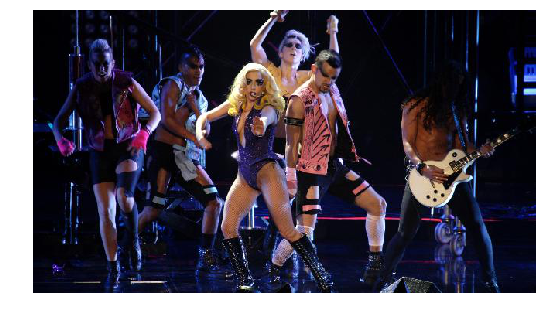

In [45]:
# get the size of the image
(image_width, image_height) = pil_image.size

# big images difficult in jupyter notebooks ...
if image_width > 1024 or image_height > 1024:
    
    # figure out the base width for image
    basewidth = min(image_width,1024)
    
    # what percentage is this a reduction
    wpercent = (basewidth/float(image_width))
    
    # figure out size for scaled height
    hsize = int((float(image_height)*float(wpercent)))
    
    # do resize
    pil_image = pil_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)
    
    # update the size of the image
    (image_width, image_height) = pil_image.size
    
# blab about the final image dimensions
print 'image dimensions: {} pixels'.format((image_width,image_height))

# show the image
show_image(pil_image)

Deep learning models do not know anything about "JPEG" or "PNG" etc.  The API models only take as input arrays or matrices of numbers. Therefore, we must convert the PIL image into an arrays of pixel values. Furthremore, the model expects a 4D matrix where a single RGB color image has dimensions (1,H,W,C) where H is the number of pixels in the vertical direction, W is the number of pixels in the horizontal, and C is the number of color "channels" usually 3 for RGB.  Although sometimes depth field (from LiDAR etc) is included so C would be 4 in that case.  These types of images are refered to as "[RGB-D](http://rgbd.cs.princeton.edu/)" If we were working with video (i.e. a sequence of N imag frames) or a pair of stero images etc then the generic size of the 4D input matrix would be (N,H,W,C).  Just as an example, suppose the network input was 1-second of color video at 30 frames per second (fps) with 640 by 480 resolution.  Then the input tensor would have dimensions (30,480,640,3).  If the network input was a pair of 1024x1024 grayscale stereo images then the input tensor would have dimensions (2,1024,1024,1) where the final C dimension is 1 since there is only a single grayscale pixel value between 0 and 1 versus a color pixel value defined by three numbers R, G, and B.   

In [46]:
%%time

# specify new dimensions for image (note w,h swap)
new_image_dims = (image_height,image_width,3)

# now, convert PIL image into NumPy array
image_np = np.array(pil_image.getdata())

# reshape the array 
image_np = image_np.reshape(new_image_dims).astype(np.uint8)

# convert the array to unsigned 8-bit interger type
image_np = image_np.astype(np.uint8)

# add 4th dimension
image_np_expanded = np.expand_dims(image_np, axis=0)

# blab about the final array size 
print('np array dimensions: {}'.format(image_np.shape))

# blab about the expanded tensor size
print('image array expanded dimensions: {}'.format(image_np_expanded.shape))


np array dimensions: (366, 650, 3)
image array expanded dimensions: (1, 366, 650, 3)
CPU times: user 185 ms, sys: 12.8 ms, total: 198 ms
Wall time: 197 ms


### 1.4 Model Inference
- creating the appropriate scope to reuse our session
- creating references to tensors within the TensorFlow model
- running the session with prepared tensor
- understanding timing performance

Now that we have an image we are ready to apply our model 

In [47]:
# we can use the session we created above as default so we do not have to pay init cost every invocation
with detection_graph.as_default():
  with sess.as_default():
    
    # a reference or handle to the "input" tensor for the graph
    image_tensor_TF   = sess.graph.get_tensor_by_name('image_tensor:0'     )
    
    # references or handles to the the "output" tensors in the graph
    boxes_TF          = sess.graph.get_tensor_by_name('detection_boxes:0'  )
    scores_TF         = sess.graph.get_tensor_by_name('detection_scores:0' )
    classes_TF        = sess.graph.get_tensor_by_name('detection_classes:0')
    num_detections_TF = sess.graph.get_tensor_by_name('num_detections:0'   )
    
    # we need to tell the sesion to use our image tensor as input 
    # to do this we create a dictionary mapping of input tensors references to our numpy array
    input_mapping = {image_tensor_TF: image_np_expanded}
    
    # we next need to tell TF about which tensors to collect for us once 
    # the input tensor we've specified has been pushed thorugh the network graph
    # so, lets just create a list of tensors we'd like to get back after invocation
    fetches = [boxes_TF, scores_TF, classes_TF, num_detections_TF]
    
    # run session and colect the outputs 
    (boxes, scores, classes, num_detections) = sess.run(fetches,feed_dict=input_mapping)
    
    # in human words this says, please invoke the model associated with the session "sess"
    # using python variable "image_np_expanded" as the starting value for the "image_tensor"
    # Once the compute graph has completed, go fetch the values for aforementioned tensors
    # and map them to python variables "boxes", "socres", "classes", and "num_detections" 

#### Sanity Check:
Add the **`%%time`** cell-instruction to the to the cell above to time the model invocation/inference. 

The model inference time will depend on which model has been selected.  Also, the platform running the model will have a significant impact on the timing as well. Typically, DLI labs use a cloud service such as AWS which is a virtualized GPU resource which incurres some latency overhead.  Finally, these models come packages with an image pre-processing pipeline which performs all kinds of manipulations to the input such as resizing, mean subtraction, and on and on.  Notice, that our basic image resizing and tensor preparations have already consumed a few hundred milliseconds and we pay for more pre-processing upon model invocation!  For minimum latency, you will need to engineer the pre-processing pipeline for your particular application.  

### 1.5 Understanding Model Output

All models for the TensorFlow Object Detection API provide four outputs: 
1. boxes - detection bounding boxes
2. scores - sorted model confidence between 0 and 1 for the detection (bbox and classifications)
3. classes - each detection is classified into a particular object category such as car, traffic sign, person, etc
4. num_detections - Most of the models provide a static 100 detections every time, Faster R-CNN will output 300

Notice, that detections from the models are provided in order of maximum model confidence. That is, desending order of score. So, therefore the first detection boxes[0,1] is the most confident detection from the network and so on.  You might wonder what to do with 100 detections if there are only 6 objects in the scene!  The standard practice is to discard detections under a particular threshold value (usually score of 0.5 which is 50% confidence).  Notice that the network might produce multiple detections for the same object so it is not impossible to get 13 valid detections for 8 objects and so on.  For now, this is just food for thought.  We will dive more into these details later. 

In [48]:
# each detection is associated with a bounding box encapsulating the area of interest
# depending on which model you use, you will get 100 or 300 bounding boxes returned
# these bboxes are defined as [ymin, xmin, ymax, xmax]
boxes[0,0:4,:]

array([[ 0.19767919,  0.34400719,  0.9893558 ,  0.55316323],
       [ 0.09338686,  0.06510051,  0.91981053,  0.22901523],
       [ 0.10731196,  0.49828795,  0.89696968,  0.63319796],
       [ 0.12527201,  0.19457743,  0.94121766,  0.35130003]], dtype=float32)

In [49]:
# each detection is associated with a confidence between 0 and 1
# notice that the networks return detections sorted by confidence
# that is first detection has highest score and so on
scores[0,0:4]

array([ 0.91980088,  0.8323586 ,  0.63499528,  0.55614233], dtype=float32)

In [50]:
# each detection is associated with a numerical category id.  We will use coco annotatios definitions to decode
classes[0,0:4]

array([ 1.,  1.,  1.,  1.], dtype=float32)

### 1.6 Working With Model Output
- manipulating/transforming bbox values
- using PIL to display bboxes for detections
- creating human readable labels for detections
- using PIL to annotate bboxes with labels


We have all the detection content from the network for the image.  What we would like to do now is to start annotating the image with detection information.  We can choose any detection we would like between `0` and `num_detections-1`.  Once we choose the detection we'd like to annotate, we need to get the associated bounding box coordinates, detection confidence, and human label.  With these data we add the bounding box rectatangle to the image and create a compact label to attach to the bbox to complete the annotation. 

In [51]:
# define the detection index to show
dix = 0;

# get the bound box for this detection
bbox = boxes[0,dix,:]

# format is: ymin, xmin, ymax, xmax
(ymin,xmin,ymax,xmax) = bbox

# convert normalized coordinates to absolute
xmin *= image_width ; xmax *= image_width; 
ymin *= image_height; ymax *= image_height

It is very important to notice that we have to normalize the bbox coordinates before we can add them to the image.  The network produces normalized coordinates between 0 and 1.  This allows the bboxes to map back to any size image regardless of whatever internal image size the network uses.  Conversion from normalized [0,1] coordinates back into absolute pixel dimensions is quite simple -- just multiply x-coordinates by the original image width and the y-coordinates by the number of pixels in the image vertical.  There is nothing complicated about this, just a bit of book keeping we have to keep track of.  

In [52]:
# pil image coordinates have origin at upper left corner -- assign for readability
(left, right, top, bottom) = (xmin, xmax, ymin, ymax)

In [53]:
# initialize a drawing handel associated with our image
pil_img_draw = ImageDraw.Draw(pil_image)

# draw lines between bbox points counter-clockwise order
pil_img_draw.line(
      [
          (left , top   ), # starting point
          (left , bottom), # left edge of bbox
          (right, bottom), # bottom edge of bbox
          (right, top   ), # right edge of bbox
          (left , top   )  # top edge of bbox 
      ]
  )

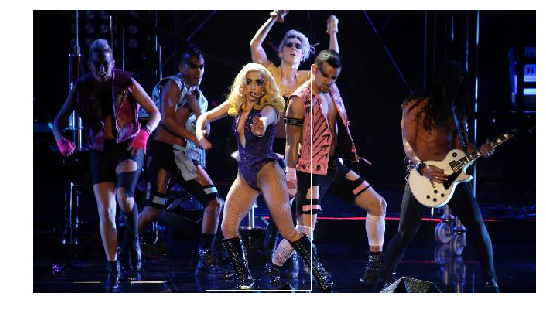

In [54]:
# show the image with bounding box
show_image(pil_image)

Now lets see how confident the network is for this detection and figure out the object category

In [55]:
# get the score/confidence for this detection (between zero and one)
detection_confidence = scores[0,dix]

# get the associated class for this detection
category_id = int(classes[0,dix])

# get the label for this category identifier using the index built from coco annotations file in beginning 
# that is, convert category ID from the network to human readable label for this detection
label = class_id_index[category_id]

# make a statement ...
print 'The network is {:.2f} % confident that this is a {:s}'.format(detection_confidence*100,label)

The network is 91.98 % confident that this is a person/person


Lets create a tag to add to the bounding box to form a more complete image annotation

In [56]:
# lets load the default system font
font = ImageFont.load_default()

# create formated string for bbox label
bbox_label = '{0}: {1:.2f}'.format(label,scores[0,dix]*100)

# figure out the width and height of the detection label for to add to image
text_width, text_height = font.getsize(bbox_label)

# comfort signal to give us some feedback
print 'pixel size of bbox label is {} pixels wide by {} pixels tall'.format(text_width,text_height)

pixel size of bbox label is 120 pixels wide by 11 pixels tall


Now that we have the bbox label and we know the text size in units of pixels, we can just create another rectangle anchored at the top left corner of the bounding box, fill the rectangle with color background, and add text to the image at the specific location inside that rectangle. 

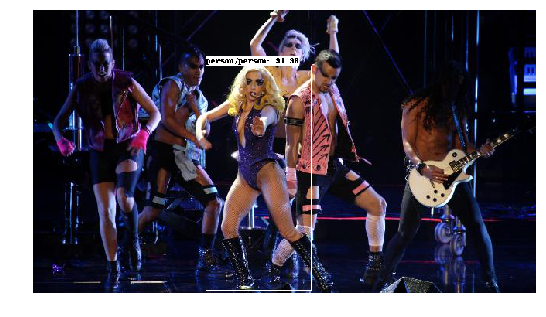

In [57]:
# draw a solid rectangle at top left corner of the bbox to host the detection label

# we want the rectable to be just a bit bigger than the actual text (note: font size dependent)
padding = np.ceil(0.05 * text_height)

# upper left point of text box (just above the upper left point of the bounding box)
ulp = (left, top - (text_height + 2 * padding))

# lower right point of the text rectangle (along the top of the bbox)
lrp = (left+text_width, top)

# draw the rectangle on the PIL image anchored to bbox
pil_img_draw.rectangle([ulp,lrp],fill='White')

# finally we need to add the actual text label on to the image
pil_img_draw.text(
        (left + padding, top - (text_height + padding)),
        bbox_label,
        fill='black',
        font=font)

# show the PIL image
show_image(pil_image)

Again, notice that there is nothing particularly complicated about adding the additional rectangle and text.  Indeed, this is a bit of busy work to calculate the proper location and sizes. However, once coded to your preference and liking, you can forget about the details and use those brain cycles for more important things like evaluating detector performace. 

#### Sanity Check:
Repeat this section for the next/another detection from the network.  That is, update the detection index, `dix`, and work again through the cells to add bounding box and detection label.  

#### 1.7 Building Your Intuition
Now that we have completed a single image, go back through and try some different images that are relevant to your own work.  If you want to have some fun or need some inspiration, here are a few image suggestions from round the internet (mostely from Wikimedia) [*right click img link and copy URL*].

| Content       |  Link             |
|:------------- |:-------------:|
|Lenna |[img](https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png)|
| Monterey Bay Aquarium | [img](https://visitmontereybay.files.wordpress.com/2015/08/capture1.png)|
| Abbey Road | [img](https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg)|
|Sgt. Pepper|[img](https://upload.wikimedia.org/wikipedia/en/5/50/Sgt._Pepper%27s_Lonely_Hearts_Club_Band.jpg)|
|Marvel XMen |[img](https://i.annihil.us/u/prod/marvel//universe3zx/images/e/e2/XMenInline4.jpg)|
|Highway in Germany|[img](https://upload.wikimedia.org/wikipedia/commons/9/97/Blick_auf_A_2_bei_Rastst%C3%A4tte_Lehrter_See_%282009%29.jpg)|
|Gridlock Canada|[img](https://upload.wikimedia.org/wikipedia/commons/5/5d/401_Gridlock.jpg)|
|Tight Quarters Atlanta|[img](https://upload.wikimedia.org/wikipedia/commons/b/ba/Atlanta_75.85.jpg)|
|Public Transport Korea|[img](https://upload.wikimedia.org/wikipedia/commons/4/4d/Gyeongbu_Expressway_Bus_Only_Lane.JPG)|

Right-click the img link to *copy image URL*.  Also, if want to navigate to the image, ctrl-click the link to open in a new tab rather than your current Jupyter notebook browser window.

An important part of this exersize is to make an initial hypothesis about where you think the network will place the next detection.  Does that network order the detections in the order you think is correct?  Does the network prefer (bias) the right or left side of the image?  Does the network process the foreground before objects in the background?  How does the network deal with groups of objects?

Of course, do not hesitate to load a different model and compare network inference time and accuracy of detection results.  



#### Extra Credit
For an image:

1. [easy] Calculate how many detections with confidence greater than 0.5
2. [easy-ish] Summarize the image content of the image (i.e. maybe tally each unique category)
3. [easy-ish] Create a color index that maps object categories to particular color of bounding box
4. [less easy] Calculate and plot the CDF of the detection scores for a few images.  What can we tell from the curves?

### 2.8  Summary
Lets just summarize the bulk computations (tedium) we performed in this section ...

In [58]:
# helper function to convert TF bbox rel to abs
def tf_bbox_rel_to_abs(pil_image,bbox):
    
    # bbox = list(ymin,xmin,ymax,xmax) coords in [0,1]
    
    # get the image dimensions
    w,h = pil_image.size
    
    # format is: ymin, xmin, ymax, xmax
    (ymin,xmin,ymax,xmax) = bbox

    # convert normalized coordinates to absolute
    xmin *= w; xmax *= w
    ymin *= h; ymax *= h
    
    # we're done (note potential np.array to list
    return [ymin,xmin,ymax,xmax]


# function to provide image and tensor for url 
def image_for_url(url):
    
    # open the url for reading
    fd = urllib.request.urlopen(url)

    # read the bytes 
    image_bytes = io.BytesIO(fd.read())

    # init PIL image with bytes from URL
    pil_image = PIL.Image.open(image_bytes)
    
    # get the size of the image
    (image_width, image_height) = pil_image.size

    # big images difficult in jupyter notebooks ...
    if image_width > 1024 or image_height > 1024:

        # figure out the base width for image
        basewidth = min(image_width,1024)

        # what percentage is this a reduction
        wpercent = (basewidth/float(image_width))

        # figure out size for scaled height
        hsize = int((float(image_height)*float(wpercent)))

        # do resize
        pil_image = pil_image.resize((basewidth,hsize), PIL.Image.ANTIALIAS)

        # update the size of the image
        (image_width, image_height) = pil_image.size
        
    # specify new dimensions for image (note w,h swap)
    new_image_dims = (image_height,image_width,3)

    # now, convert PIL image into NumPy array
    image_np = np.array(pil_image.getdata())

    # reshape the array 
    image_np = image_np.reshape(new_image_dims).astype(np.uint8)

    # convert the array to unsigned 8-bit interger type
    image_np = image_np.astype(np.uint8)

    # add 4th dimension
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # we're done 
    return pil_image,image_np_expanded,
    
    
def draw_bbox(pil_image, bbox, label=None, color=None):

    # pid = PIL.Image.Draw
    
    # keep it readable
    (ymin,xmin,ymax,xmax) = bbox
    
    # pil image coordinates have origin at upper left corner -- assign for readability
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    
    # check the color, default if needed
    if color is None: color = 'White'
        
    # init image draw context
    pid = ImageDraw.Draw(pil_image)
    
    # draw lines between bbox points counter-clockwise order
    pid.line(
      [
          (left , top   ), # starting point
          (left , bottom), # left edge of bbox
          (right, bottom), # bottom edge of bbox
          (right, top   ), # right edge of bbox
          (left , top   )  # top edge of bbox 
      ],
        fill=color
    )
    
    # if there is not label then we're done
    if label is None: return
    
    # lets load the default system font
    font = ImageFont.load_default()

    # figure out the width and height of the detection label for to add to image
    text_width, text_height = font.getsize(label)
    
    # we want the rectable to be just a bit bigger than the actual text (note: font size dependent)
    padding = np.ceil(0.05 * text_height)

    # upper left point of text box (just above the upper left point of the bounding box)
    ulp = (left, top - (text_height + 2 * padding))

    # lower right point of the text rectangle (along the top of the bbox)
    lrp = (left+text_width, top)

    # draw the rectangle on the PIL image anchored to bbox
    pid.rectangle([ulp,lrp],fill=color)
    
    # compute the anchor point of the text
    text_anchor_point = (left + padding, top - (text_height + padding))

    # finally we need to add the actual text label on to the image
    pid.text(text_anchor_point, label, fill='black', font=font)
    

#### Sanity Check:
Use these functions to add all the detections with a threshold of at least 0.5 to your image

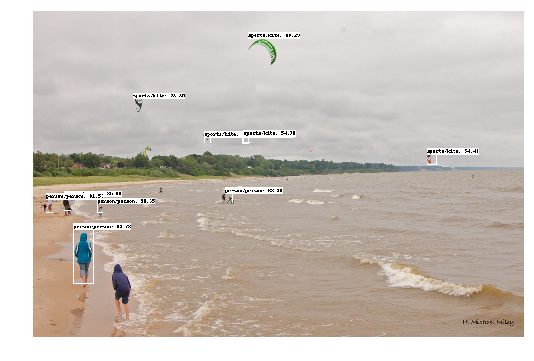

In [59]:
# image from internet
url = 'https://farm5.staticflickr.com/4009/4678754542_fd42c6bbb8_b_d.jpg'

# get an image from the internet
pil_image,image_tensor = image_for_url(url)

# detect stuff 
with detection_graph.as_default():
  with sess.as_default():
    image_tensor_TF   = sess.graph.get_tensor_by_name('image_tensor:0'     )
    boxes_TF          = sess.graph.get_tensor_by_name('detection_boxes:0'  )
    scores_TF         = sess.graph.get_tensor_by_name('detection_scores:0' )
    classes_TF        = sess.graph.get_tensor_by_name('detection_classes:0')
    num_detections_TF = sess.graph.get_tensor_by_name('num_detections:0'   )
    
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes_TF, scores_TF, classes_TF, num_detections_TF],
        feed_dict={image_tensor_TF: image_tensor})
    
# iterate over detections
for dix in range(num_detections):
    
    # if threshold too low move along
    if scores[0,dix] < 0.5: continue
        
    # convert the bbox rel to abs coordinates
    bbox = tf_bbox_rel_to_abs(pil_image, boxes[0,dix])
    
    # create label for this detection based on class and score
    bbox_label = '{0}: {1:.2f}'.format(
        class_id_index[int(classes[0,dix])],
                            scores[0,dix]*100)
    
    # add the detection to the image
    draw_bbox(pil_image,bbox,bbox_label,'White')
    
# show the annotated result
show_image(pil_image,(12,6))

#### Sanity Check
Try again with the lower resolution ([medium](https://farm5.staticflickr.com/4009/4678754542_fd42c6bbb8_z_d.jpg)) version of this image.  Do you notice any differences in the detection results?

### Part 2 - Working with COCO Dataset Annotations

Now we are going to work with the [COCO dataset](http://mscoco.org/).  The idea is that we need a dataset with ground truth annotations to test our object detector(s).  We are interested in this dataset because it is large (+80,000 images) with content from 80 different object categories such as vehicles and people. Many images are well annotated having both object bounding boxes as well as pixel mask associated with each object in the scene to facilitate object segmentation also.  For more details on this dataset see [here](https://arxiv.org/abs/1405.0312).

In this section we will review the basic algorithms for bounding box overlap and intersection over union so stay tuned!

### 2.1 Manipulating COCO Annotations
- understanding organization of COCO annotations
- build mapping between image IDs and their associated annotations
- calculating some statistics over the entire dataset
- pulling images from COCO server and summarizing content

The annotations for the COCO dataset are provided as a big huge JSON file 

In [60]:
# define a relative path to the coco annotations JSON definitions 
json_annotations_file_path = os.path.join('coco','annotations','instances_train2017.json')

In [61]:
# calculate the size of the annotations file
fsize = os.path.getsize(json_annotations_file_path)/1024/1024

# blab about it
print 'The size of the COCO annotations file is {} MB'.format(fsize)

The size of the COCO annotations file is 448 MB


When we read in this file, python parses all of the json data and returns a the whole thing as a dictionary.

In [ ]:
# we already did this at the beginging but do it again if you need/want to
# import the coco annotation information (big file, takes a few seconds) 
with open(json_annotations_file_path) as dat: data = json.load(dat)

In [62]:
# make note about the type return from json.load()
print 'The data type returned from json.load() is of type {:s}'.format(type(data))

The data type returned from json.load() is of type <type 'dict'>


To start to get a feel for what is inside of this thing lets just print the keys out to have a look

In [63]:
for k in data.keys():
    print k

info
licenses
images
annotations
categories


We can query any of the keys to get additional content.  For example, we used the `categories` key at the begining of this lab to create a lookup table for the network category IDs so that we could translate the numerical object labels from the detector.  Likewise, we will now use the `annotations` key to build a mapping between image IDs and their associated annotations (which includes bounding boxes). 

#### Sanity Check
Have a look at the `info` and `licenses` content for the annotations data

In [64]:
# your code here

Lets have a look at the image content here.  We see it is a list of dictionaries.  That is a dictionary for each image entry 

In [65]:
# what is the data type of the images content
type(data['images'])

list

In [66]:
# hm, how many entries are there (hint: many)
len(data['images'])

118287

In [67]:
# ok, well what is the type of each image in the list?
type(data['images'][0])

dict

In [68]:
# lets have a look at an image entry
data['images'][2819]

{u'coco_url': u'http://images.cocodataset.org/train2017/000000278961.jpg',
 u'date_captured': u'2013-11-15 15:09:15',
 u'file_name': u'000000278961.jpg',
 u'flickr_url': u'http://farm9.staticflickr.com/8189/8139328497_9731b444fa_z.jpg',
 u'height': 640,
 u'id': 278961,
 u'license': 1,
 u'width': 480}

What we see is that the images content for each image includes things like a unique identifier, image dimensions (width, height), capture date, and various resource locators (URLs). Finally, we note that there are annotations for 82783 images in this metadata file. 

Lets do the same exercise for the `annotations` content

In [69]:
# what is the data type of the images content
type(data['annotations'])

list

In [70]:
# how many individual annotations do we have here ?
len(data['annotations'])

860001

#### Sanity Check:
Have a look at a randomly selected annotation

In [71]:
# your code here

One of the first things you might notice is that there are a huge number of annotations here -- more than 600,000 of them.  Each annotation is tagged with a unique image identifier that associates it with an image. However, these annotations are in random order so we need to be able to pick out all the annotations from this big collection for a particular image of interest. Finally, hopefully you noticed that every annotation defines a bounding box (`bbox`) and most have associated `segmentation` mask defined as ordered verticies of a polygon with the format (x,y,x,y,...).

Finall, we have enough information about the layout of this metadata to build the mapping between unique image ids and annotations.  The basic idea is that for each image id, we create a bucket.  Then we simply iterate over the annotations and based on the annotation `image_id` we just put the annotation is the bucket with the same ID.  

In [72]:
# build an index that maps images to there associated COCO annotation definitions

# init empty dictionary for annotation index
annotation_index = dict()

# iterate over annotations and consolodate image IDs
for annotation in data['annotations']:
    
    # get the associated image id for this annotation
    img_id = annotation['image_id']
    
    # do we know about this image id yet?
    if not img_id in annotation_index:
        
        # if not, initialize index entry for image id (i.e. a bucket)
        annotation_index[img_id] = list()
        
    # add the annotation to the associated image (bucket)
    annotation_index[img_id].append(annotation)

With this new index we can now compute some interesting statistics on the COCO dataset.  For example, we can compute the histogram of *annotations per image* over the dataset.  This is just a few lines of code and quite informative.

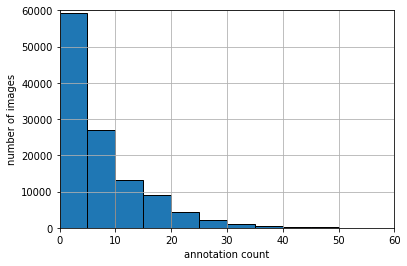

mean: 7, max: 93


In [73]:
# compute the number of annotations per image
annotations_per_image = [len(v) for v in annotation_index.values()]

# the histogram of the number of annotations per image
plt.hist(annotations_per_image,bins=range(0,70,5),edgecolor='black')

# configure the histogram
plt.xlabel('annotation count')
plt.ylabel('number of images')
plt.axis([0, 60, 0, 60000])
plt.grid(True)
plt.show()

# compute some interesting statistics
print "mean: {0:0.0f}, max: {1}".format(np.mean(annotations_per_image),np.max(annotations_per_image))

Notice the exponential decay of the bin counts. Using this kind of information, you might be interested in which images have 20 or more annotations for a particular detector stress test etc. 

Finally, lets grab a random COCO image to work with.  Recall in the previous section we could simply grab an image if we had it's associated URL -- and all the coco image dictionaries have a `coco_url` defined.  

In [74]:
# get a random coco image definition

# figure out number of images defined
num_coco_images = len(data['images'])

# calculate a random index
rix = random.choice(range(num_coco_images))

# grab the json node for this image
image_metadata = data['images'][rix]

# the COCO id for this image
image_id = image_metadata['id']

# get the URL for this image
url = image_metadata['coco_url']

# blab about it
print 'we can get the image for image {} at {}'.format(image_id, url)

we can get the image for image 99402 at http://images.cocodataset.org/train2017/000000099402.jpg


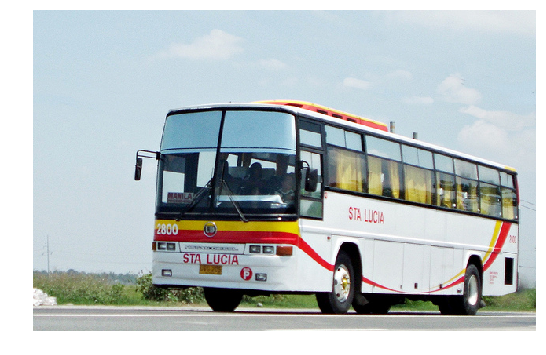

In [75]:
# pull down the image from the coco server
pil_image,image_tensor =  image_for_url(url)

# show the image
show_image(pil_image)

Lets get the associated annotations for this images and summarize the content

In [76]:
# lets now get the coco annotations for this image
image_annotations = annotation_index[image_id]

# count the number of annotations for this image
print 'There are {} official coco annotations for image {}'.format(len(image_annotations),image_id)

# init empty tally index
coco_annotation_count = collections.Counter()

# generate tally for each object/category type
for obj in image_annotations: coco_annotation_count[obj['category_id']] += 1
    
# sort the tallys
coco_annotation_tallys = sorted(coco_annotation_count.items(), key=operator.itemgetter(1), reverse=True)

# print the categories
for tally in coco_annotation_tallys:
    print '{:2d} coco annotation of category {}'.format(tally[1],class_id_index[tally[0]])

There are 4 official coco annotations for image 99402
 3 coco annotation of category person/person
 1 coco annotation of category vehicle/bus


Be sure to work through the summary and try to identify the image content.  For some images it can be a little challenging to find all the annotated objects.  

#### Sanity Check:
Repeat this exersize a few more times to pull down some COCO images and summarize content.

#### Extra Credit:
1. [easy-ish] build a map of categories to image IDs.  This makes it easy to find images with particular content of interest (say, more than 5 cars and at least 3 people and 1 bycicle)
2. [easy-ish] for each category, compute number of instances over all images.  How well is your category of interest represented in the COCO dataset?

### 2.2 Working with COCO Annotations
- formating COCO bounding box definitions
- adding COCO annotations to images
- figuring out which annotations are associated with a particular detection

Now that we have all the annotations for an image we would like to be able to visualize them overlaid on the image.  We did exactly this in the previous section where we visualized the bounding boxes returned from the TensorFlow networks.  Lets just do the same thing here with the COCO annotation bounding boxes.  This only catch is that the COCO annotation bboxes are in a different format than bboxes from the detector.  Recall that the TF detector bboxes have format `(ymin,xmin,ymax,xmax)` normalized while the COCO bboxes have the format `(xmin,ymin,width,height)` absolute.  Therefore, we simply need to compute (ymax,xmax) the COCO boxes to visualize them with the same codes we used above.  

In [77]:
# a simple function to convert COCO bbox to TF (ymin,xmin,ymax,xmax) format

def coco_bbox_format_to_tf(bbox):
    
    #bbox = list(x,y,w,h) in abs coords
    
    # assign for readability
    x,y,w,h = bbox
    
    # compute tf coords
    xmin = x
    ymin = y
    xmax = x + w
    ymax = y + h
    
    # we're done
    return [ymin,xmin,ymax,xmax]

Lets use this to add the COCO bounding boxes to our COCO image

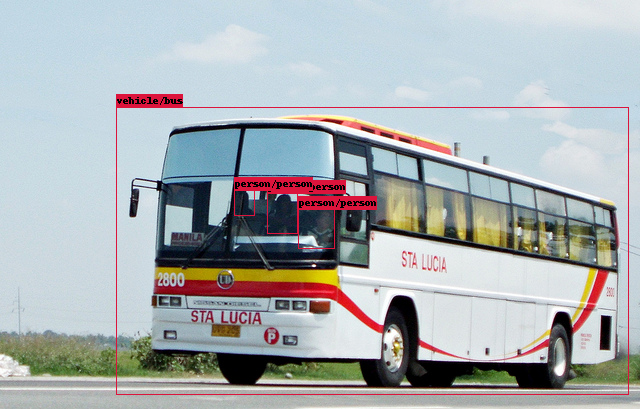

In [78]:
# iterate over annotations and add associated bounding boxes to image
for annotation in annotation_index[image_id]:
    
    # get the bounding box
    bbox = annotation['bbox']
    
    # convert the bbox format for image display
    bbox = coco_bbox_format_to_tf(bbox)
    
    # get the object category for this annotation 
    category_id = annotation['category_id']
    
    # use human category description as the bbox label
    label = class_id_index[category_id]
    
    # finally, add the annotation bbox with object label
    draw_bbox(pil_image,bbox,label,'Crimson')
    
pil_image

Perfect, now lets invoke the network object detection on this image and see what we pick up

In [79]:
with detection_graph.as_default():
  with sess.as_default():
    b   = sess.graph.get_tensor_by_name('image_tensor:0'     )
    boxes_TF          = sess.graph.get_tensor_by_name('detection_boxes:0'  )
    scores_TF         = sess.graph.get_tensor_by_name('detection_scores:0' )
    classes_TF        = sess.graph.get_tensor_by_name('detection_classes:0')
    num_detections_TF = sess.graph.get_tensor_by_name('num_detections:0'   )
    
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes_TF, scores_TF, classes_TF, num_detections_TF],
        feed_dict={image_tensor_TF: image_tensor})

Plot the detections over the annotations to have a quick look

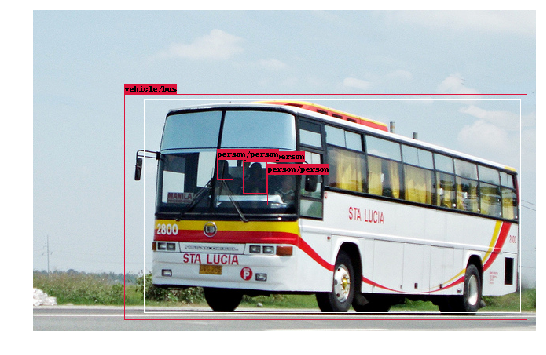

In [80]:
# iterate over detections
for dix in range(num_detections):
    
    # if threshold too low move along
    if scores[0,dix] < 0.5: continue
        
    # convert the bbox rel to abs coordinates
    bbox = tf_bbox_rel_to_abs(pil_image, boxes[0,dix])
    
    # add the detection to the image
    draw_bbox(pil_image,bbox,None,'White')
    
# show result
show_image(pil_image)

#### Sanity Check:
Repeat this process a few more times for random COCO images to get a good feel for how detections overlap with annotations.

### 2.3 Scoring Detections and Evaluating Detector Performance
- Overlap test help with detection association ... kinda
- Discuss how to proceed with missed detections
- Computing intersection over union (IoU)
- Greedy IoU scoring strategy

As you can see after a few iterations of overlaying detections and annotations, matching the detections to the appropriate annotations for performance evaluation might not be so trivial.  It is possible for many annotations to overlap with a single detection.  How then to score the detection with respect to the ground truth annotations? 

We can easily compute bounding box overlap between detections and annotations with the following function

In [81]:
def bbox_do_overlap_tf_abs(A,B):
    
    # A = list(ymin,xmin,ymax,xmax)
    # B = list(ymin,xmin,ymax,xmax)
    
    # just do it ... compute x,y,w,h for both boxes
    ax = A[1]; ay = A[0]; aw = A[3]-A[1]; ah = A[2]-A[0]
    bx = B[1]; by = B[0]; bw = B[3]-B[1]; bh = B[2]-B[0]
    
    # simple test and we're done
    return (abs(ax - bx) * 2 < (aw + bw)) and (abs(ay - by) * 2 < (ah + bh))

However, what is potentially worse is that is that for a given images how do we score missed detections?  To get a feel for this situation, check out COCO image [56664](http://mscoco.org/images/56664).  There are 43 official COCO annotations for this image but MobileNet `model_0` only produces 6 detections above the 0.5 confidence threshold.  One might (correctly) argue that this is potentially more an issue with the annotations rather than the network detector. None the less, figuring out a scoring process for particular images is quite difficult when working with generic datasets.  Furthermore, for situations like autonomous drivng, it is considerable difficult to score missed detections.  For example, a missed detection could be a vehicle on the other side of highway across the median in the opposite direction.  Does a missed detection of that object affect the the ability of the autonomous driving system?  Very difficult questions to answer in general.  This leads to a dataset-wide performance metrics where performance is evaluated per class rather than per image. Detector precision for each category is computed over the entire dataset.  Then the mean precision over all categories is computed to provide mean average precision (mAP).  

The strategy often used to score detections is for each detection compute the IoU over all unmatched annotations and then select the annotation associated with the maximum IoU.  Lets give this strategy a whirl ...

Computing the intersection over union is fairly straight forward -- figure out the coordinates of the overlapping rectangle, compute the area of this intersection and compute `areaI/(areaA + areaB - areaI)`.  If the calculation of the coordinates for the intersecting rectangle look strange, just sit in a quiet place with a coffee, pen, and paper for a bit and convince yourself.  The only other "GOTCHA" in this calculation is "negative area" -- which happens only when there is definitively no bounding box overlap.  Therefore we just take the max of the calculated widths and heights w.r.t. zero to keep things physical. Otherwise, this calculation is just basic stuff: `area = w*h`, don't let the book keeping confuse you. 

In [82]:
# function to compute the intersection over union of these two bounding boxes
def bbox_IoU(A, B):
    
    # A = list(ymin,xmin,ymax,xmax)
    # B = list(ymin,xmin,ymax,xmax)
    
    # assign for readability 
    yminA, xminA, ymaxA, xmaxA = A
    yminB, xminB, ymaxB, xmaxB = B
    
    # figure out the intersecting rectangle coordinates
    xminI = max(xminA, xminB)
    yminI = max(yminA, yminB)
    xmaxI = min(xmaxA, xmaxB)
    ymaxI = min(ymaxA, ymaxB)
    
    # compute the width and height of the intereseting rectangle
    wI = xmaxI - xminI
    hI = ymaxI - yminI
 
    # compute the area of intersection rectangle (enforce area>=0)
    areaI = max(0,wI) * max(0,hI)
    
    # if intersecting area is zero, we're done (avoids IoU=0/0 also)
    if areaI == 0: return 0
 
    # compute areas of the input bounding boxes 
    areaA = (xmaxA - xminA) * (ymaxA - yminA)
    areaB = (xmaxB - xminB) * (ymaxB - yminB)
 
    # finally, compute and return the intersection over union 
    return areaI / (areaA + areaB - areaI)

Lets test this out by computing the IoU of a particular detection w.r.t. all COCO annotations 

In [83]:
# init empty
iou = list()

# index of a detection
dix = 0

# get the abs bbox associated with detection
d_bbox = tf_bbox_rel_to_abs(pil_image,boxes[0,dix])

# compute IoU w.r.t. to all annotations
for annotation in annotation_index[image_id]:
    
    # get the annotation bbox in tf format
    a_bbox = coco_bbox_format_to_tf(annotation['bbox'])
    
    # compute iou
    iou.append(bbox_IoU(d_bbox,a_bbox))    

Notice that there are likely multiple non-zero IoU:

In [84]:
# manually (by eye) inspect the IoUs
print iou

[0.88158304864948456, 0.010778752919772379, 0.009077549471370799, 0.0039029657443949975]


We then match this detection with the annotation having maximum IoU.

In [85]:
# figure out the index of the maxium IoU annotation
mix = np.argmax(iou)

# get the associated annotation
matching_annotation = annotation_index[image_id][mix]

# get the label for the detection category
d_label = class_id_index[int(classes[0,dix])]

# get the label for the annotation category
a_label = class_id_index[matching_annotation['category_id']]

# blab about it
print 'detection {:d} ({:s}) matching annotation {:d} ({:s}) with max(IoU) {:.2f}'.format(dix,d_label,mix,a_label,iou[mix])


detection 0 (vehicle/bus) matching annotation 0 (vehicle/bus) with max(IoU) 0.88


Turn all this into a helper function

In [86]:
def max_IoU_annotation(bbox,annotations):
    
    # init empty
    iou = list()
    
    # compute IoU w.r.t. to all annotations
    for ax in annotations:
    
        # get the annotation bbox in tf format
        a_bbox = coco_bbox_format_to_tf(ax['bbox'])

        # compute iou
        iou.append(bbox_IoU(bbox,a_bbox))
        
    # index of arg max
    ix = np.argmax(iou)
        
    # arg max and associated annotation
    return ix,iou[ix],annotations[ix]
    

Finally, lets repeat this process for all valid detections

In [87]:
# get copy of annotations list (so we can remove items safely)
alist = copy.deepcopy(annotation_index[image_id])

# init empty list of matching/max annotations
mlist = list()

# init empty list of max iou values for labeling
ilist = list()

# init empty list of index values
ixlist = list()

# loop over detections one-by-one
for dix in range(num_detections):
    
    # if below threshold, move along
    if scores[0,dix] < 0.5: continue
    
    # get the abs bbox associated with detection
    d_bbox = tf_bbox_rel_to_abs(pil_image,boxes[0,dix])
    
    # get max IoU annotation w.r.t. to detction bounding box
    mix, miou, max_annotation = max_IoU_annotation(d_bbox,alist) 
    
    # keep track of results
    mlist.append(max_annotation); ilist.append(miou); ixlist.append(mix)
    
    # note this allows for duplicate matches, should delete matched annotations from alist (!!)


And now, plot the final matching results

detection 0 (vehicle/bus) matching annotation 0 (vehicle/bus) with max(IoU) 0.88


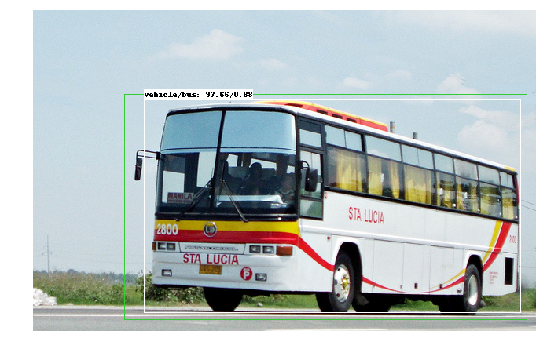

In [88]:
# pull down the image from the coco server
pil_image,image_tensor =  image_for_url(url)

# iterate over detections
for dix in range(num_detections):
    
    # if threshold too low move along
    if scores[0,dix] < 0.5: continue
        
    # convert the bbox rel to abs coordinates
    bbox = tf_bbox_rel_to_abs(pil_image, boxes[0,dix])
    
    # create label for this detection based on class and score
    d_bbox_label = '{0}: {1:.2f}'.format(
        class_id_index[int(classes[0,dix])],
                            scores[0,dix]*100)
    
    # if the max IoU is approx zero then move along
    if ilist[dix] <= 0.01: continue
        
    # get the associated annotation
    matching_annotation = mlist[dix]
    
    # index of max iou
    mix = ixlist[dix]
    
    # value of the max IoU
    max_iou = ilist[dix]

    # get the label for the detection category
    d_label = class_id_index[int(classes[0,dix])]

    # get the label for the annotation category
    a_label = class_id_index[matching_annotation['category_id']]
    
    # create format string
    info_string = 'detection {:d} ({:s}) matching annotation {:d} ({:s}) with max(IoU) {:.2f}'

    # blab about it
    print info_string.format(dix,d_label,mix,a_label,max_iou)
        
    # get the bounding box for this annotation abs
    a_bbox = coco_bbox_format_to_tf(matching_annotation['bbox'])
    
    # annotation bbox color 
    a_color = 'LimeGreen'
    
    # if categories match annotation box is green
    if not d_label == a_label: a_color = 'Crimson'
        
    # finally update detection bounding box label with associated max IoU
    d_bbox_label = d_bbox_label + '/' + '{:.2f}'.format(max_iou) 
    
    # add max IoU matching detection 
    draw_bbox(pil_image,a_bbox,None,a_color)
    
    # add the detection with label to the image
    draw_bbox(pil_image,bbox,d_bbox_label,'White')
    
# show the annotated result
show_image(pil_image)

Note that we still have possiblility for duplicate matching annotations.  Also, if you repeate this process for a many random COCO images, you will see that often a quite small maximum IoU value for some detection-annotation match.  Often these low max-IoU associations fail to match in object category.  It would be reasonable to add a minimum max-IoU threshold to catch these cases.  Just some food for thought.   

### 2.4 Summary
Congratulations for making it all the way to the end!  We've learned how to shread through the COCO annotations, pull down test images from the COCO data servers and match detections with annotations using intersection over union.  No doubt there has been a large amount of book keeping -- probably more book keeping than deep learning!  But that's the way it goes sometimes.  You should now have a essential understanding of how to utilize the Object Detection API in TensorFlow as well as the core skills to evaluate object detection performance.  Be sure to play around with all the five available models and do not hesitate to create/test your own performance metrics.  As you have probably noticed, sometimes the detectors can do weird things even though the model mAP looks strong, so be sure to test test test. 

Don't hesitate to reach out with questions or comments at: `abelb@nvidia.com`

## Answers to Exercises 